# Equation de convection - diffusion 1D
## Méthode des volumes-finis

### Cas 1d : écoulement à vitesse constante

La variable scalaire $\Phi$ est transportée par convection et diffusion dans un écoulement à vitesse constante et connue ($u$) traversant un domaine mono-dimensionnel, voir la figure ci-dessous où figurent les conditions limites du problème. 

La solution analytique du problème s'écrit 
$ \dfrac{\Phi -\Phi_0}{\Phi_L -\Phi_0}  = \left({\exp{\left(\dfrac{\rho u x}{\Gamma}\right)} -1} \right) / \left({\exp{\left(\dfrac{\rho u L}{\Gamma}\right)} -1} \right)$

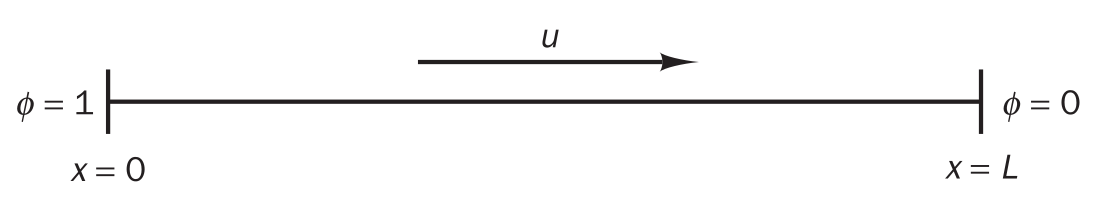

In [1]:
from IPython.display import display, Image, Math
i=Image(filename='fig/diff_conv_exemple.png', width=600)
display(i)

Soit à résoudre le problème de transport 1D par convection-diffusion 

$  \dfrac{d}{dx}(\rho u \Phi) =  \dfrac{d}{dx} \left( \Gamma \frac{d\Phi}{dx} \right) \quad \textrm{pour} \quad 0<x<L,
  \textrm{avec} \quad \Phi(0)=\Phi_A=1, \quad \Phi(L)=\Phi_B=0 $
  
On utilisera un maillage décalé **régulier** à faces centrées, tout d'abord à 5 volumes de contrôle.

In [2]:
i=Image(filename='fig/dessin.png', width=600)
display(i)

In [3]:
# python packages
import sys
sys.path.append('src')
get_ipython().run_line_magic('matplotlib', 'inline')

import numpy as np
import matplotlib.pylab as plt

import scipy.sparse as sp
from scipy.sparse.linalg import spsolve

%matplotlib inline

np.set_printoptions(linewidth=130)

In [4]:
# source files
from grid_module import *            # mesh 
from properties_module import *      # physical properties definition
from solver_module import *          # operators
from bc_module import *              # boundary conditions    Gamx = gamma_x * np.ones (dim_sca)

 # 1. Set the problem parameters: boundary conditions and mesh

In [5]:
# physical parameters
Lx = 1.
xstart = 0 ; xend = Lx 
Ly = 1.
ystart = 0 ; yend = 1.

Uval    = 0.1          # 0.1 2.5 -0.1 -2.5
rhoval  = 1.
gamma_x = 0.1

# boundary conditions
C0 = 1    # BC x = 0
CL = 0    # BC x = L
U0 = Uval # BC x = 0
UL = Uval # BC x = L

In [6]:
# mesh (complete the grid_module.py file)

# number of inner nodes  = number of unknowns
m = 5               # F-V number (5 10 50)

# 1D test case
n = 1

# Numerical grid for the fluid
x = reg_grid(m, xstart, xend)     # x: velocity positions
y = reg_grid(n, ystart, yend)     # y: velocity positions

# Mesh and sizes of variables on inner nodes
dx, xp, dim_sca,   dxp, xu, dim_U, dxu = coordinates(m, x)
dy, yp, dim_sca_y, dyp, yv, dim_V, dyv = coordinates(n, y)

# 1D test case
print(x,  '\n',  y) # face positions including boundary conditions
print(xp, '\n', yp) # node positions
print(xu, '\n', yv) # face positions excluding boundary conditions

[0.  0.2 0.4 0.6 0.8 1. ] 
 [0. 1.]
[0.1 0.3 0.5 0.7 0.9] 
 [0.5]
[0.2 0.4 0.6 0.8] 
 []


<Figure size 432x288 with 0 Axes>

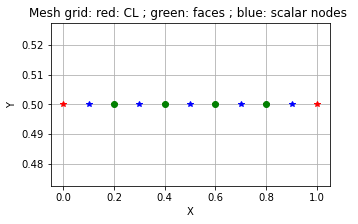

In [7]:
# mesh visualization

plt.figure()
XCL, YCL = np.meshgrid(x,  yp)
XU, YU   = np.meshgrid(xu, yp)
XP, YP   = np.meshgrid(xp, yp)

fig = plt.figure(figsize=(5,3))
plt.plot(XCL, YCL, 'r*');
plt.plot(XU,   YU, 'go');
plt.plot(XP,   YP, 'b*');

plt.xlabel("X")
plt.ylabel('Y')
plt.title( "Mesh grid: red: CL ; green: faces ; blue: scalar nodes " )

plt.grid(True)

plt.show()

# 2. Plot and print the exact solution on the scalar mesh

In [8]:
# Complete the function

def Cexact (x):
    
    """ function exacte given x : position """
    
    f = ((np.exp(rhoval*Uval*x/gamma_x) - 1) / (np.exp(rhoval*Uval*Lx/gamma_x) - 1)) * (CL-C0) + C0 # exacte solution equation depending on xp
    
    return f

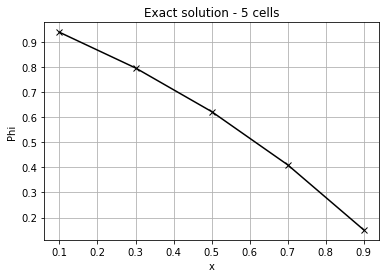

xp(  0  ) =  0.10,   Cexact (  0  ) = 0.938792975
xp(  1  ) =  0.30,   Cexact (  1  ) = 0.796390323
xp(  2  ) =  0.50,   Cexact (  2  ) = 0.622459331
xp(  3  ) =  0.70,   Cexact (  3  ) = 0.410019538
xp(  4  ) =  0.90,   Cexact (  4  ) = 0.150544988


In [9]:
# Visualize and print the exact solution

sol_exact = Cexact(xp)

fig=plt.figure()
plt.plot(xp, sol_exact,'kx-')

plt.title(f"Exact solution - {m} cells")
plt.xlabel('x')
plt.ylabel('Phi')

plt.grid(True)

plt.savefig('Figures/Cexacte.png')

plt.show()

for j in range(0, np.size(sol_exact)):
        print('xp({0:3d}  ) =  {1:3.2f},   Cexact ({0:3d}  ) = {other:7.9f}'.format(j, xp[j], other=sol_exact[j]))
        

# 3. Calculate the physical properties on the velocity mesh

In [10]:
# physical properties estimated on the VF faces (complete the properties_module.py file)

Gamx_ew, rho_ew = prop_phys(dim_sca, dim_U, gamma_x, rhoval)

print(Gamx_ew) # Vectorization gamma_x

# ew scalar values at nodes but used for fluxes at interfaces. Thus "Gamx_ew" is a function at interface.

[[0.1]
 [0.1]
 [0.1]
 [0.1]]


### Demonstration BC

$$\frac{F_e}{2}(\phi_E + \phi_P) - \frac{F_w}{2}(\phi_W + \phi_P) = D_e(\phi_E - \phi_P) - D_w(\phi_P - \phi_W)$$

At node 1 :

$$\frac{F}{2}(\phi_E + \phi_W) - F\phi_A = D(\phi_E - \phi_W)$$

and so :

$$(\frac{F}{2} + D + 2D)\phi_W = (D - \frac{F}{2})\phi_E + (F + 2D)\phi_A$$ with this last term accounting for BC. 

Similarly, one get the BC at node 5 :
$$(\frac{F}{2} + D + 2D)\phi_E = (D + \frac{F}{2})\phi_W + (-F + 2D)\phi_B$$ 

As a conclusion : 
- $(F + 2D)\phi_A$ at node 1
- $(-F + 2D)\phi_B$ at node 5

# 4. Solve the diffusive problem

In [11]:
# declarations

matA   = np.eye(m)                   # the whole matrix including inner nodes and BC nodes
BB     = np.zeros(np.array([m-2,m])) # diffusive part of matA
bcW    = np.zeros(np.array([1, m]))  # BC row of matA
bcE    = np.zeros(np.array([1, m]))  # BC row of matA

source = np.zeros(dim_sca)           # source vector
SbcW,  SbcE = 0., 0.                 # BC elements of Source

In [12]:
### matrix construction (complete the solver_module.py file)

mass      = sp.diags([dy], [0], (m, m)).toarray() # dy into a diagonal matrix
Div, Grad = gradiv(m, dxp) # divergence, gradient

BB = mass[1:-1,1:-1]@(Div@(Gamx_ew*Grad))
matA[1:-1,:] = BB

### boundary conditions (complete the bc_module.py file)

bcW[0,1]   = BB[0,2]     # matA[1,2]   # a_E unchanged
bcE[0,-2]  = BB[-1,-3]   # matA[-2,-3] # a_W unchanged

bcW[0,0]   = matA[1,1]   # a modifier par bc
bcE[0,-1]  = matA[-2,-2] # a modifier par bc

bcW, bcE, SbcW, SbcE = bc_diff(bcW, bcE, SbcW, SbcE, m, x, xp, dxp,C0, CL, gamma_x, Gamx_ew, mass)

# assembling
matA       = np.concatenate((bcW[:], matA[1:-1,:], bcE[:]), axis=0)
source[0]  = SbcW
source[-1] = SbcE

# --------------------------------

print(matA)

[[-1.5  0.5  0.   0.   0. ]
 [ 0.5 -1.   0.5  0.   0. ]
 [ 0.   0.5 -1.   0.5  0. ]
 [ 0.   0.   0.5 -1.   0.5]
 [ 0.   0.   0.   0.5 -1.5]]


In [13]:
### Resolution by a sparse solver : spsolve

# declaration of solution field
c_sol     = np.ones(shape=m+2)
c_sol[0]  = C0
c_sol[-1] = CL

# solving
CC          = sp.csr_matrix(matA)
c_sol[1:-1] = spsolve(CC,source)

# --------------------------------

print('Solution case 1 : \n%s' %c_sol[1:-1].reshape(-1,1))

Solution case 1 : 
[[0.9]
 [0.7]
 [0.5]
 [0.3]
 [0.1]]


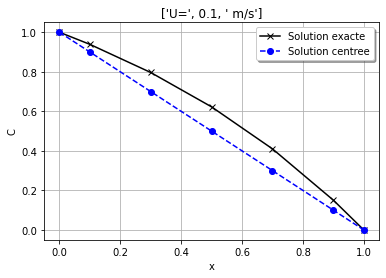

xtot(  0  ) =  0.00,   c_VF (  0  ) = 1.000000000,   Cexact (  0  ) = 1.000000000
xtot(  1  ) =  0.10,   c_VF (  1  ) = 0.900000000,   Cexact (  1  ) = 0.938792975
xtot(  2  ) =  0.30,   c_VF (  2  ) = 0.700000000,   Cexact (  2  ) = 0.796390323
xtot(  3  ) =  0.50,   c_VF (  3  ) = 0.500000000,   Cexact (  3  ) = 0.622459331
xtot(  4  ) =  0.70,   c_VF (  4  ) = 0.300000000,   Cexact (  4  ) = 0.410019538
xtot(  5  ) =  0.90,   c_VF (  5  ) = 0.100000000,   Cexact (  5  ) = 0.150544988
xtot(  6  ) =  1.00,   c_VF (  6  ) = 0.000000000,   Cexact (  6  ) = 0.000000000


In [14]:
# FIGURE

xtot        = np.ones(shape=m+2)
xtot[1:m+1] = xp
xtot[0]     = xstart
xtot[-1]    = xend

Cexact = (CL-C0)*(np.exp(rhoval*Uval*xtot/gamma_x) - 1)/(np.exp(rhoval*Uval*xend/gamma_x)-1) + C0

# --------------------------------

plt.figure()
plt.plot(xtot, Cexact,'kx-')
plt.plot(xtot, c_sol,'bo--')

plt.xlabel('x')
plt.ylabel('C')
plt.title(['U=', Uval, ' m/s'])

plt.legend(('Solution exacte', 'Solution centree'), loc='best', shadow=True)
plt.grid(True)

# --------------------------------

plt.savefig('Figures/C_Diff_centred.png')
plt.show()

for j in range(0,np.size(Cexact)):
        print('xtot({0:3d}  ) =  {1:3.2f},   c_VF ({0:3d}  ) = {2:7.9f},   Cexact ({0:3d}  ) = {other:7.9f}'.format(j,xtot[j],c_sol[j],other=Cexact[j]))

**On remarcque que l'approximation linéaire amène bien une évoultion linéaire qui n'approche donc que partiellement la fonction de déplacement $\phi$.**

# 5. Solve the convective-diffusive problem

# I.a $u_1 = 0.1$ $m.s^{-1}$

In [15]:
# declarations
# Ux : vector at the VF faces

Ux = Uval * np.ones(dim_U) # Uval = 0.1

In [16]:
### matrix (complete the solver_module.py file)

Int = interp(m)  # centred interpolation 
AA  = mass[1:-1,1:-1]@Div@(Int*Ux)
matA[1:-1,:] += - AA

# --------------------------------

### boundary conditions (complete the bc_module.py file)

bcW[0,1]  = matA[1,2]    # a_E unchanged
bcE[0,-2] = matA[-2,-3]  # a_W unchanged

bcW, bcE, SbcW, SbcE = bc_interp(bcW, bcE,SbcW, SbcE, U0, UL,C0,CL,rhoval,rho_ew,Ux,mass)

# --------------------------------

# assembling
matA       = np.concatenate((bcW[:], matA[1:-1,:], bcE[:]), axis=0)
source[0]  = SbcW
source[-1] = SbcE

print(matA)

[[-1.55  0.45  0.    0.    0.  ]
 [ 0.55 -1.    0.45  0.    0.  ]
 [ 0.    0.55 -1.    0.45  0.  ]
 [ 0.    0.    0.55 -1.    0.45]
 [ 0.    0.    0.    0.55 -1.45]]


In [17]:
### Resolution by a sparse solver: spsolve

# initialisation of solution field
c_sol     = np.ones(shape=m+2)
c_sol[0]  = C0
c_sol[-1] = CL

# solving
CC          = sp.csr_matrix(matA)
c_sol[1:-1] = spsolve(CC,source)

print('Solution case 2 : \n %s' %(c_sol[1:-1].reshape(-1,1)))

Solution case 2 : 
 [[0.94210996]
 [0.80060097]
 [0.62764554]
 [0.41625556]
 [0.15789004]]


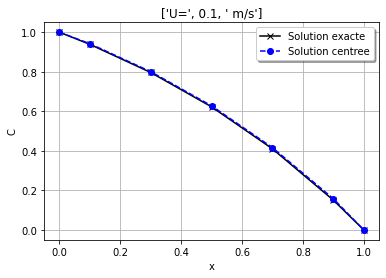

xtot(  0  ) =  0.00,   c_VF (  0  ) = 1.000000000,   Cexact (  0  ) = 1.000000000
xtot(  1  ) =  0.10,   c_VF (  1  ) = 0.942109959,   Cexact (  1  ) = 0.938792975
xtot(  2  ) =  0.30,   c_VF (  2  ) = 0.800600969,   Cexact (  2  ) = 0.796390323
xtot(  3  ) =  0.50,   c_VF (  3  ) = 0.627645536,   Cexact (  3  ) = 0.622459331
xtot(  4  ) =  0.70,   c_VF (  4  ) = 0.416255564,   Cexact (  4  ) = 0.410019538
xtot(  5  ) =  0.90,   c_VF (  5  ) = 0.157890041,   Cexact (  5  ) = 0.150544988
xtot(  6  ) =  1.00,   c_VF (  6  ) = 0.000000000,   Cexact (  6  ) = 0.000000000


In [18]:
# FIGURE

xtot        = np.ones(shape=m+2)
xtot[1:m+1] = xp
xtot[0]     = xstart
xtot[-1]    = xend

Cexact = C0+(CL-C0)*(np.exp(rhoval*Uval*xtot/gamma_x)-1)/(np.exp(rhoval*Uval*xend/gamma_x)-1)

# --------------------------------

plt.figure()

plt.plot(xtot, Cexact, 'kx-')
plt.plot(xtot, c_sol, 'bo--')

plt.xlabel('x')
plt.ylabel('C')
plt.title(['U=', Uval, ' m/s'])

plt.legend(('Solution exacte', 'Solution centree'), loc='best', shadow=True)
plt.grid(True)

# --------------------------------

plt.savefig('Figures/C_CDiff_centred.png')
plt.show()

for j in range(0,np.size(Cexact)):
        print('xtot({0:3d}  ) =  {1:3.2f},   c_VF ({0:3d}  ) = {2:7.9f},   Cexact ({0:3d}  ) = {other:7.9f}'.format(j,xtot[j],c_sol[j],other=Cexact[j]))

# I.b $u_2 = 2.5$ $m.s^{-1}$

In [19]:
# declarations
# Ux : vector at the VF faces

Uval = 2.5
Ux   = Uval * np.ones(dim_U) # Uval = 2.5

In [20]:
### matrix (complete the solver_module.py file)

Int  = interp(m)  # centred interpolation 

AA = mass[1:-1,1:-1]@Div@(Int*Ux)

matA[1:-1,:] += - AA

# --------------------------------

### boundary conditions (complete the bc_module.py file)

bcW[0,1]  = matA[1,2]    # a_E unchanged
bcE[0,-2] = matA[-2,-3]  # a_W unchanged

bcW, bcE, SbcW, SbcE = bc_interp(bcW, bcE, SbcW, SbcE, U0, UL, C0, CL, rhoval, rho_ew, Ux, mass)

# --------------------------------

# assembling
matA       = np.concatenate((bcW[:], matA[1:-1,:], bcE[:]), axis=0)
source[0]  = SbcW
source[-1] = SbcE

In [21]:
### Resolution by a sparse solver: spsolve

# initialisation of solution field
c_sol     = np.ones(shape=m+2)
c_sol[0]  = C0
c_sol[-1] = CL

# solving
CC          = sp.csr_matrix(matA)
c_sol[1:-1] = spsolve(CC,source)

print('Solution case 3 : \n %s' %(c_sol[1:-1].reshape(-1,1)))

Solution case 3 : 
 [[1.04431941]
 [0.84488206]
 [1.2936161 ]
 [0.28396451]
 [2.55568059]]


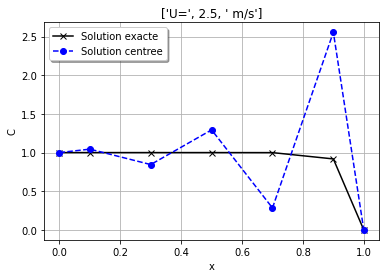

xtot(  0  ) =  0.00,   c_VF (  0  ) = 1.000000000,   Cexact (  0  ) = 1.000000000
xtot(  1  ) =  0.10,   c_VF (  1  ) = 1.044319411,   Cexact (  1  ) = 1.000000000
xtot(  2  ) =  0.30,   c_VF (  2  ) = 0.844882060,   Cexact (  2  ) = 0.999999975
xtot(  3  ) =  0.50,   c_VF (  3  ) = 1.293616100,   Cexact (  3  ) = 0.999996273
xtot(  4  ) =  0.70,   c_VF (  4  ) = 0.283964510,   Cexact (  4  ) = 0.999446916
xtot(  5  ) =  0.90,   c_VF (  5  ) = 2.555680589,   Cexact (  5  ) = 0.917915001
xtot(  6  ) =  1.00,   c_VF (  6  ) = 0.000000000,   Cexact (  6  ) = 0.000000000


In [22]:
# FIGURE

xtot        = np.ones(shape=m+2)
xtot[1:m+1] = xp
xtot[0]     = xstart
xtot[-1]    = xend

Cexact = C0+(CL-C0)*(np.exp(rhoval*Uval*xtot/gamma_x)-1)/(np.exp(rhoval*Uval*xend/gamma_x)-1)

# --------------------------------

plt.figure()

plt.plot(xtot, Cexact, 'kx-')
plt.plot(xtot, c_sol, 'bo--')

plt.xlabel('x')
plt.ylabel('C')
plt.title(['U=', Uval, ' m/s'])

plt.legend(('Solution exacte', 'Solution centree'), loc='best', shadow=True)
plt.grid(True)

# --------------------------------

plt.savefig('Figures/C_CDiff_centred.png')
plt.show()

for j in range(0,np.size(Cexact)):
        print('xtot({0:3d}  ) =  {1:3.2f},   c_VF ({0:3d}  ) = {2:7.9f},   Cexact ({0:3d}  ) = {other:7.9f}'.format(j,xtot[j],c_sol[j],other=Cexact[j]))

$\Rightarrow$ **One can see that the approached solution tries at each node to get back to aimed value, but as the speed of $\phi$ is quiet high, it results the solution isn't well approached. In fact, the numerical solution oscillate around analytical one with x increasing.**

**To conclude, the overall form remains at low speed while it tends to diverge with the x increasing when speed is too high.**

Let's now see if the result can be better approximated with a finner mesh.

# II. Finner Mesh

In [23]:
# CHANGE M ACCORDING TO WHAT YOU WANT TO SAY
m = 5

# 1D test case
n = 1

# -------------------------------
# -------------------------------

# Numerical grid for the fluid
x = reg_grid(m, xstart, xend)  # x: velocity positions
y = reg_grid(n, ystart, yend)     # y: velocity positions
    
# Mesh and sizes of variables on inner nodes
dx, xp, dim_sca,   dxp, xu, dim_U, dxu = coordinates(m, x)
dy, yp, dim_sca_y, dyp, yv, dim_V, dyv = coordinates(n, y)

# -------------------------------
# -------------------------------

# physical properties estimated on the VF faces (complete the properties_module.py file)
Gamx_ew, rho_ew = prop_phys(dim_sca, dim_U, gamma_x, rhoval)

# -------------------------------
# -------------------------------

# declarations Matrices

matA   = np.eye(m)                   # the whole matrix including inner nodes and BC nodes
BB     = np.zeros(np.array([m-2,m])) # diffusive part of matA
bcW    = np.zeros(np.array([1, m]))  # BC row of matA
bcE    = np.zeros(np.array([1, m]))  # BC row of matA

source = np.zeros(dim_sca)           # source vector
SbcW,  SbcE = 0., 0.                 # BC elements of Source

In [24]:
## Matrix construction

# --------------------------------

## Add diffusive term

mass = sp.diags([dy], [0], (m, m)).toarray() # dy into a diagonal matrix
Div, Grad = gradiv(m, dxp) # divergence, gradient

BB = mass[1:-1,1:-1]@(Div@(Gamx_ew*Grad))
matA[1:-1,:] = BB

# --------------------------------

## boundary conditions

bcW[0,1]  = BB[0,2]     # matA[1,2]   # a_E unchanged
bcE[0,-2] = BB[-1,-3]   # matA[-2,-3] # a_W unchanged

bcW, bcE, SbcW, SbcE = bc_diff(bcW, bcE, SbcW, SbcE, m, x, xp, dxp,C0, CL, gamma_x, Gamx_ew, mass)

## assembling
matA       = np.concatenate((bcW[:], matA[1:-1,:], bcE[:]), axis=0)
source[0]  = SbcW
source[-1] = SbcE

# --------------------------------
# --------------------------------
# --------------------------------

## Add convective term

Uval = .1
Ux   = Uval * np.ones(dim_U) # Uval = 2.5

Int  = interp(m)  # centred interpolation 
AA   = mass[1:-1,1:-1]@Div@(Int*Ux)
matA[1:-1,:] += - AA

# --------------------------------

## boundary conditions

bcW[0,1]  = matA[1,2]    # a_E unchanged
bcE[0,-2] = matA[-2,-3]  # a_W unchanged

bcW, bcE, SbcW, SbcE = bc_interp(bcW, bcE,SbcW, SbcE, U0, UL,C0,CL,rhoval,rho_ew,Ux,mass)

## assembling
matA       = np.concatenate((bcW[:], matA[1:-1,:], bcE[:]), axis=0)
source[0]  = SbcW
source[-1] = SbcE

# --------------------------------
# --------------------------------
# --------------------------------

### Resolution by a sparse solver: spsolve

# initialisation of solution field
c_sol     = np.ones(shape=m+2)
c_sol[0]  = C0
c_sol[-1] = CL

# solving
CC          = sp.csr_matrix(matA)
c_sol[1:-1] = spsolve(CC,source)

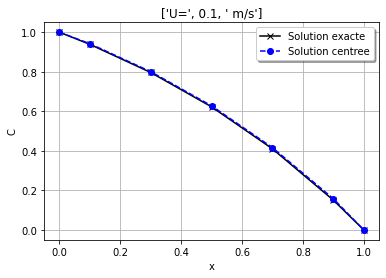

xtot(  0  ) =  0.00,   c_VF (  0  ) = 1.000000000,   Cexact (  0  ) = 1.000000000
xtot(  1  ) =  0.10,   c_VF (  1  ) = 0.942109959,   Cexact (  1  ) = 0.938792975
xtot(  2  ) =  0.30,   c_VF (  2  ) = 0.800600969,   Cexact (  2  ) = 0.796390323
xtot(  3  ) =  0.50,   c_VF (  3  ) = 0.627645536,   Cexact (  3  ) = 0.622459331
xtot(  4  ) =  0.70,   c_VF (  4  ) = 0.416255564,   Cexact (  4  ) = 0.410019538
xtot(  5  ) =  0.90,   c_VF (  5  ) = 0.157890041,   Cexact (  5  ) = 0.150544988
xtot(  6  ) =  1.00,   c_VF (  6  ) = 0.000000000,   Cexact (  6  ) = 0.000000000


In [25]:
# FIGURE

xtot        = np.ones(shape=m+2)
xtot[1:m+1] = xp
xtot[0]     = xstart
xtot[-1]    = xend

Cexact = C0+(CL-C0)*(np.exp(rhoval*Uval*xtot/gamma_x)-1)/(np.exp(rhoval*Uval*xend/gamma_x)-1)

# --------------------------------

plt.figure()

plt.plot(xtot, Cexact, 'kx-')
plt.plot(xtot, c_sol, 'bo--')

plt.xlabel('x')
plt.ylabel('C')
plt.title(['U=', Uval, ' m/s'])

plt.legend(('Solution exacte', 'Solution centree'), loc='best', shadow=True)
plt.grid(True)

# --------------------------------

plt.savefig('Figures/C_CDiff_centred.png')
plt.show()

for j in range(0,np.size(Cexact)):
        print('xtot({0:3d}  ) =  {1:3.2f},   c_VF ({0:3d}  ) = {2:7.9f},   Cexact ({0:3d}  ) = {other:7.9f}'.format(j, xtot[j], c_sol[j], other=Cexact[j]))

$\Rightarrow$ **One can see there are no more oscillations for the numerical solution, that now fits expected result.**

**To have increase the number of VC thus correct approximation from numerical calculations.**

## L2 norm - relative error

<ipython-input-26-69ac8ef57c80>:3: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(xtot, (np.abs(c_sol - Cexact)/Cexact), color='orange')


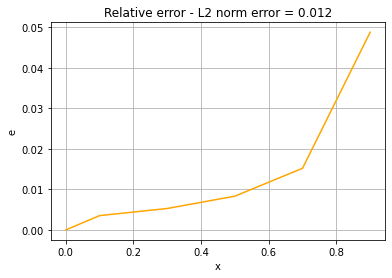

In [26]:
## Error - L2 norm

plt.plot(xtot, (np.abs(c_sol - Cexact)/Cexact), color='orange')

plt.title('Relative error - L2 norm error = {:.3f}'.format((np.sum(np.abs(c_sol - Cexact)**2))**.5))
plt.xlabel('x')
plt.ylabel('e')

plt.grid(True)

## Max displacement - location

In [27]:
## YOU MAY HAVE TO RESTART THE KERNELL IF YOU WANT TO TEST OTHERS CASES OR RERUN CURRENT ONE

# Max displacement

disp     = np.abs(c_sol - Cexact)
max_disp = np.max(disp)

# Position where max is :

pos_disp = np.where(disp == max_disp)[0][0] - 1 # -1 as we previously considered m+1 to build xp
x_max    = xp[pos_disp]

print('Max displacement is {:.4f} m and is located in xp = {:.3f}'.format(max_disp, x_max))

Max displacement is 0.0073 m and is located in xp = 0.900


$\Rightarrow$ **One can see that the approached solution now better fits exact one.
However, if one increase furthermore the speed, previous result is to be obtained again. Therefore, finner the mesh, better the solution, but this has limit.**

Let's now look at a mesh whose meshing is made out of a cosinusoidal repartition.

# III Cosinusoidal Meshing

<Figure size 432x288 with 0 Axes>

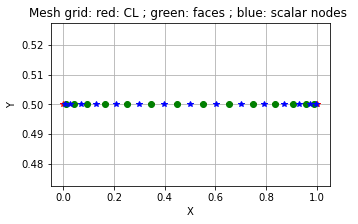

In [28]:
# CHANGE M ACCORDING TO WHAT YOU WANT TO SAY
m = 15

# 1D test case
n = 1

# -----------------------------

## Mesh building

x = np.zeros((m+1))

# Numerical grid for the fluid
for j in range(m+1):
    x[j] = (xend - xstart) * .5 * (1 - np.cos(j*np.pi/m))  # x: velocity positions

y = reg_grid(n, ystart, yend)  # y: velocity positions
    
# Mesh and sizes of variables on inner nodes
dx, xp, dim_sca,   dxp, xu, dim_U, dxu = coordinates(m, x)
dy, yp, dim_sca_y, dyp, yv, dim_V, dyv = coordinates(n, y)

# -----------------------------

## Mesh visualization

plt.figure()
XCL, YCL = np.meshgrid(x,  yp)
XU, YU   = np.meshgrid(xu, yp)
XP, YP   = np.meshgrid(xp, yp)

fig = plt.figure(figsize=(5,3))
plt.plot(XCL, YCL, 'r*');
plt.plot(XU,   YU, 'go');
plt.plot(XP,   YP, 'b*');

plt.xlabel("X")
plt.ylabel('Y')
plt.title( "Mesh grid: red: CL ; green: faces ; blue: scalar nodes " )

plt.grid(True)

plt.show()

$\Rightarrow$ **The mesh then does't have equidistant points. Moreover, we tigthen up the positions of BC and first node such that they'll get mixed for large number of cells.**

**In the end, this creates an offset due to the proximity mesh/edge. The quantity then transported isn't in accordance with targeted one.**

Let's see this through a graph :

In [29]:
# physical properties estimated on the VF faces (complete the properties_module.py file)
Gamx_ew, rho_ew = prop_phys(dim_sca, dim_U, gamma_x, rhoval)

# -------------------------------
# -------------------------------

# declarations Matrices

matA   = np.eye(m)                   # the whole matrix including inner nodes and BC nodes
BB     = np.zeros(np.array([m-2,m])) # diffusive part of matA
bcW    = np.zeros(np.array([1, m]))  # BC row of matA
bcE    = np.zeros(np.array([1, m]))  # BC row of matA

source = np.zeros(dim_sca)           # source vector
SbcW,  SbcE = 0., 0.                 # BC elements of Source

In [30]:
## Matrix construction

# --------------------------------

## Add diffusive term

mass = sp.diags([dy], [0], (m, m)).toarray() # dy into a diagonal matrix
Div, Grad = gradiv(m, dxp) # divergence, gradient

BB = mass[1:-1,1:-1]@(Div@(Gamx_ew*Grad))
matA[1:-1,:] = BB

# --------------------------------

## boundary conditions

bcW[0,1]  = BB[0,2]     # matA[1,2]   # a_E unchanged
bcE[0,-2] = BB[-1,-3]   # matA[-2,-3] # a_W unchanged

bcW, bcE, SbcW, SbcE = bc_diff(bcW, bcE, SbcW, SbcE, m, x, xp, dxp,C0, CL, gamma_x, Gamx_ew, mass)

## assembling
matA       = np.concatenate((bcW[:], matA[1:-1,:], bcE[:]), axis=0)
source[0]  = SbcW
source[-1] = SbcE

# --------------------------------
# --------------------------------
# --------------------------------

## Add convective term

Uval = 2.5
Ux   = Uval * np.ones(dim_U) # Uval = 2.5

Int  = interp(m)  # centred interpolation 
AA   = mass[1:-1,1:-1]@Div@(Int*Ux)
matA[1:-1,:] += - AA

# --------------------------------

## boundary conditions

bcW[0,1]  = matA[1,2]    # a_E unchanged
bcE[0,-2] = matA[-2,-3]  # a_W unchanged

bcW, bcE, SbcW, SbcE = bc_interp(bcW, bcE, SbcW, SbcE, U0, UL, C0, CL, rhoval, rho_ew, Ux, mass)

## assembling
matA       = np.concatenate((bcW[:], matA[1:-1,:], bcE[:]), axis=0)
source[0]  = SbcW
source[-1] = SbcE

# --------------------------------
# --------------------------------
# --------------------------------

### Resolution by a sparse solver: spsolve

# initialisation of solution field
c_sol     = np.ones(shape=m+2)
c_sol[0]  = C0
c_sol[-1] = CL

# solving
CC          = sp.csr_matrix(matA)
c_sol[1:-1] = spsolve(CC,source)

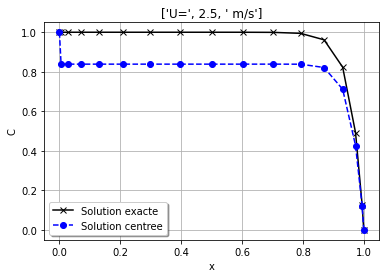

xtot(  0  ) =  0.00,   c_VF (  0  ) = 1.000000000,   Cexact (  0  ) = 1.000000000
xtot(  1  ) =  0.01,   c_VF (  1  ) = 0.838625892,   Cexact (  1  ) = 1.000000000
xtot(  2  ) =  0.03,   c_VF (  2  ) = 0.838625892,   Cexact (  2  ) = 1.000000000
xtot(  3  ) =  0.07,   c_VF (  3  ) = 0.838625892,   Cexact (  3  ) = 1.000000000
xtot(  4  ) =  0.13,   c_VF (  4  ) = 0.838625892,   Cexact (  4  ) = 1.000000000
xtot(  5  ) =  0.21,   c_VF (  5  ) = 0.838625892,   Cexact (  5  ) = 0.999999998
xtot(  6  ) =  0.30,   c_VF (  6  ) = 0.838625895,   Cexact (  6  ) = 0.999999976
xtot(  7  ) =  0.40,   c_VF (  7  ) = 0.838625862,   Cexact (  7  ) = 0.999999719
xtot(  8  ) =  0.50,   c_VF (  8  ) = 0.838626127,   Cexact (  8  ) = 0.999996273
xtot(  9  ) =  0.60,   c_VF (  9  ) = 0.838624045,   Cexact (  9  ) = 0.999950589
xtot( 10  ) =  0.70,   c_VF ( 10  ) = 0.838643403,   Cexact ( 10  ) = 0.999414851
xtot( 11  ) =  0.79,   c_VF ( 11  ) = 0.838329001,   Cexact ( 11  ) = 0.994444316
xtot( 12  ) =  0

In [31]:
# FIGURE

xtot        = np.ones(shape=m+2)
xtot[1:m+1] = xp
xtot[0]     = xstart
xtot[-1]    = xend

Cexact = C0 + (CL-C0) * (np.exp(rhoval*Uval*xtot/gamma_x)-1)/(np.exp(rhoval*Uval*xend/gamma_x)-1)

# --------------------------------

plt.figure()

plt.plot(xtot, Cexact, 'kx-')
plt.plot(xtot, c_sol, 'bo--')

plt.xlabel('x')
plt.ylabel('C')
plt.title(['U=', Uval, ' m/s'])

plt.legend(('Solution exacte', 'Solution centree'), loc='best', shadow=True)
plt.grid(True)

# --------------------------------

plt.savefig('Figures/C_CDiff_centred.png')
plt.show()

for j in range(0, np.size(Cexact)):
        print('xtot({0:3d}  ) =  {1:3.2f},   c_VF ({0:3d}  ) = {2:7.9f},   Cexact ({0:3d}  ) = {other:7.9f}'.format(j, xtot[j], c_sol[j], other=Cexact[j]))

$\Rightarrow$ **As mentioned before, the approached solution is offseted at first cell and $\phi$ quantity is thus transported as it should, but with a magnitude offset.**

**We can conclude on the fact that the mesh type takes high importance. It's then not only necessary to have as much nodes as possible, but one must ensure the mesh to be relevant with respect to the study.**

## Local Reynolds number - post-process

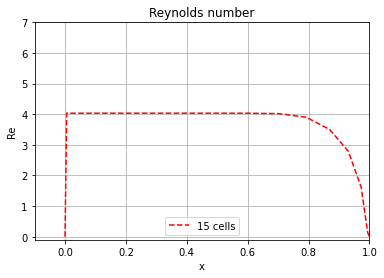

In [32]:
# Displacement
disp = np.abs(c_sol - Cexact)
Re   = rhoval * Uval * disp / gamma_x

plt.figure()
plt.plot(xtot, Re, 'r--', label=f'{m} cells')

plt.title('Reynolds number')
plt.xlabel('x')
plt.ylabel('Re')

plt.axis([-.1, 1., -.1, 7.])

plt.legend(loc=8)
plt.grid(True)

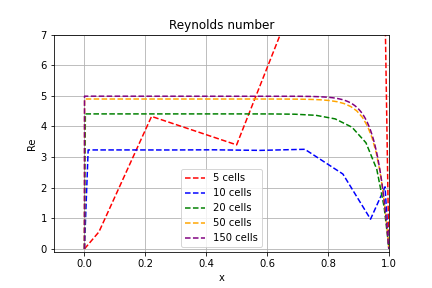

In [33]:
## Different Reynolds number

i=Image(filename='Figures/Reynolds.png', width=600)
display(i)

**A first sight, it looks like lower the number of cells, coarser is the resulting Re. Moreover, we have oscillations appearing to the right for the two first cases.**

**In fact, one can see these oscillations take place where ratio $\frac{F}{D} = \frac{\rho u \Delta x}{\Gamma}$ is greater.**

$\Rightarrow$ **This finally implies that when diffusive terms are low in front of convective terms, the solution will oscillate (at the right hand side then here).**

**We can once again fix this by increasing the number of cells, but it implies lonnger calculations as well.**

## Superposition Re - position

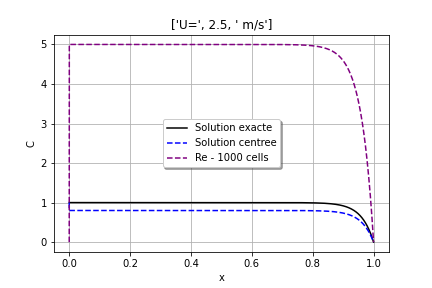

"\nCexact = C0 + (CL-C0) * (np.exp(rhoval*Uval*xtot/gamma_x)-1)/(np.exp(rhoval*Uval*xend/gamma_x)-1)\n\n# --------------------------------\n\nplt.figure()\n\nplt.plot(xtot, Cexact, 'k-')\nplt.plot(xtot, c_sol, 'b--')\nplt.plot(xtot, Re, '--', color = 'purple', label=f'150 cells')\n\nplt.xlabel('x')\nplt.ylabel('C')\nplt.title(['U=', Uval, ' m/s'])\n\nplt.legend(('Solution exacte', 'Solution centree', f'Re - {m} cells'), loc='best', shadow=True)\nplt.grid(True)\n\n# --------------------------------\n\nplt.savefig('Figures/Q4.png')\nplt.show()\n"

In [34]:
# FIGURE

i=Image(filename='Figures/Q4.png', width=600)
display(i)

"""
Cexact = C0 + (CL-C0) * (np.exp(rhoval*Uval*xtot/gamma_x)-1)/(np.exp(rhoval*Uval*xend/gamma_x)-1)

# --------------------------------

plt.figure()

plt.plot(xtot, Cexact, 'k-')
plt.plot(xtot, c_sol, 'b--')
plt.plot(xtot, Re, '--', color = 'purple', label=f'150 cells')

plt.xlabel('x')
plt.ylabel('C')
plt.title(['U=', Uval, ' m/s'])

plt.legend(('Solution exacte', 'Solution centree', f'Re - {m} cells'), loc='best', shadow=True)
plt.grid(True)

# --------------------------------

plt.savefig('Figures/Q4.png')
plt.show()
"""

$\Rightarrow$ **One can see the Reynolds number bahves as the solutions do.**

**In fact, Re here as for purpose to show what the repercussions of using an approached function are. It's a quantification of how much the Reynolds number will differ with respect to theory. Therefore, at extremities it's null while its maximal where the distance between both solution is max as well.**

**To finish, we have a post-process analysis that brings the fact that to work on appriximation might have repercussion on our fields, and consequently on useful variables that would translate the solution anymore.**

# 6. The 2D diffusive problem

In [35]:
# physical parameters
Lx = 1.
xstart = 0 ; xend = Lx 
Ly = 1.
ystart = 0 ; yend = Ly

U = V   = .1          # 0.1 2.5 -0.1 -2.5
rho     = 1.
gamma_x = .1
gamma_y = .1

## BC

# cd° phi
C_U0 = 1    # BC x = 0
C_UL = 0    # BC x = L

C_V0 = 0    # BC y = 0
C_VL = 1    # BC y = L

# cd° u
U0 = U  # BC x = 0
UL = U  # BC x = L

V0 = V  # BC y = 0
VL = V  # BC y = L

In [36]:
# mesh (complete the grid_module.py file)

# number of inner nodes  = number of unknowns
m = 5
n = 6

# Numerical grid for the fluid
x = reg_grid(m, xstart, xend)     # x: velocity positions
y = reg_grid(n, ystart, yend)     # y: velocity positions

# Mesh and sizes of variables on inner nodes
dx, xp, dim_sca,   dxp, xu, dim_U, dxu = coordinates(m, x)
dy, yp, dim_sca_y, dyp, yv, dim_V, dyv = coordinates(n, y)

<Figure size 432x288 with 0 Axes>

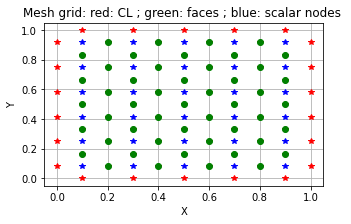

In [37]:
# mesh visualization

plt.figure()

XCL, YCL   = np.meshgrid(x,  yp)
XCL2, YCL2 = np.meshgrid(xp,  y)

XU, YU     = np.meshgrid(xu, yp)
XU2, YU2   = np.meshgrid(xp, yv)

XP, YP     = np.meshgrid(xp, yp)

# ---------------------------------

fig = plt.figure(figsize=(5,3))

# BC
plt.plot(XCL,  YCL, 'r*');
plt.plot(XCL2, YCL2, 'r*');

# Interfaces
plt.plot(XU,  YU, 'go');
plt.plot(XU2, YU2, 'go');

# Nodes
plt.plot(XP,   YP, 'b*');

# ---------------------------------

plt.xlabel("X")
plt.ylabel('Y')
plt.title( "Mesh grid: red: CL ; green: faces ; blue: scalar nodes " )

plt.grid(True)

plt.show()

In [38]:
def kron_product(n, mat):
    
    """ Function for 2D case - work with kronecker product 
    for 2D matrix building ans sytem resolution """
    
    I    = sp.eye(n)
    
    return sp.kron(I, mat, format='csr') + sp.kron(mat, I)

### Matrices X & Y

#### X

In [39]:
## Matrix construction

# physical properties estimated on the VF faces (complete the properties_module.py file)
Gamx_ew, rho_ew = prop_phys(dim_sca, dim_U, gamma_x, rho)

# -------------------------------
# -------------------------------

# declarations Matrices

matX   = np.eye(m)                   # the whole matrix including inner nodes and BC nodes

AA     = np.zeros(np.array([m-2,m])) # diffusive part of matA
bcW    = np.zeros(np.array([1, m]))  # BC row of matA
bcE    = np.zeros(np.array([1, m]))  # BC row of matA

source = np.zeros((m, n))           # source vector
SbcW,  SbcE = 0., 0.                 # BC elements of Source

# --------------------------------

## Add diffusive term

mass = sp.diags([dy], [0], (m, m)).toarray() # dy into a diagonal matrix

Div, Grad = gradiv(m, dxp) # divergence, gradient

AA = mass[1:-1,1:-1]@(Div@(Gamx_ew*Grad))

matX[1:-1,:] = AA

# --------------------------------

## boundary conditions

bcW[0,1]  = BB[0,2]     # matA[1,2]   # a_E unchanged
bcE[0,-2] = BB[-1,-3]   # matA[-2,-3] # a_W unchanged

bcW, bcE, SbcW, SbcE = bc_diff(bcW, bcE, SbcW, SbcE, m, x, xp, dxp, C_U0, C_UL, gamma_x, Gamx_ew, mass)

## assembling
matX = np.concatenate((bcW[:], matX[1:-1,:], bcE[:]), axis=0)

source[0,:]  = SbcW
source[-1,:] = SbcE

#### Y

In [40]:
## Matrix construction

# physical properties estimated on the VF faces (complete the properties_module.py file)
Gamx_ew, rho_ew = prop_phys(dim_sca_y, dim_V, gamma_y, rho)

# -------------------------------
# -------------------------------

# declarations Matrices

matY   = np.eye(n)                   # the whole matrix including inner nodes and BC nodes

BB     = np.zeros(np.array([n-2,n])) # diffusive part of matA
bcW    = np.zeros(np.array([1, n]))  # BC row of matA
bcE    = np.zeros(np.array([1, n]))  # BC row of matA

SbcW,  SbcE = 0., 0.                 # BC elements of Source

# --------------------------------

## Add diffusive term

mass = sp.diags([dy], [0], (n, n)).toarray() # dy into a diagonal matrix

Div, Grad    = gradiv(n, dyp) # divergence, gradient
BB           = mass[1:-1,1:-1]@(Div@(Gamx_ew*Grad))
matY[1:-1,:] = BB

# --------------------------------

## boundary conditions

bcW[0,1]   = BB[0,2]     # matA[1,2]   # a_E unchanged
bcE[0,-2]  = BB[-1,-3]   # matA[-2,-3] # a_W unchanged

bcW, bcE, SbcW, SbcE = bc_diff(bcW, bcE, SbcW, SbcE, n, y, yp, dyp, C_V0, C_VL, gamma_y, Gamx_ew, mass)

## assembling
matY       = np.concatenate((bcW[:], matY[1:-1,:], bcE[:]), axis=0)

source[:,0]  += SbcW
source[:,-1] += SbcE

### Convection

#### X

In [44]:
## Add convective term

U  = .5
Ux = U * np.ones(dim_U)

bcW    = np.zeros(np.array([1, m]))  # BC row of matA
bcE    = np.zeros(np.array([1, m]))  # BC row of matA

Gamx_ew, rho_ew = prop_phys(dim_sca, dim_U, gamma_x, rho)

mass = sp.diags([dy], [0], (m, m)).toarray() # dy into a diagonal matrix
Div, Grad    = gradiv(m, dxp) # divergence, gradient

Int = interp(m)  # centred interpolation 
BBX = mass[1:-1,1:-1]@Div@(Int*Ux)

matX[1:-1,:] += - BBX

# --------------------------------

## boundary conditions

bcW[0,1]  = matX[1,2]    # a_E unchanged
bcE[0,-2] = matX[-2,-3]  # a_W unchanged

bcW, bcE, SbcW, SbcE = bc_interp(bcW, bcE, SbcW, SbcE, U0, UL, C_U0, C_UL, rho, rho_ew, Ux, mass)

## assembling
matX       = np.concatenate((bcW[:], matX[1:-1,:], bcE[:]), axis=0)

source[0,:]  += SbcW
source[-1,:] += SbcE


#### Y

In [47]:
## Add convective term

V  = .5
Vy = V * np.ones(dim_V)

Gamx_ew, rho_ew = prop_phys(dim_sca_y, dim_V, gamma_y, rho)

mass = sp.diags([dy], [0], (n, n)).toarray() # dy into a diagonal matrix
Div, Grad    = gradiv(n, dyp) # divergence, gradient

bcW    = np.zeros(np.array([1, n]))  # BC row of matA
bcE    = np.zeros(np.array([1, n]))  # BC row of matA

Int = interp(n)  # centred interpolation 
BBY = mass[1:-1,1:-1]@Div@(Int*Vy)
matY[1:-1,:] += - BBY

# --------------------------------

## boundary conditions

bcW[0,1]  = matY[1,2]    # a_E unchanged
bcE[0,-2] = matY[-2,-3]  # a_W unchanged

bcW, bcE, SbcW, SbcE = bc_interp(bcW, bcE, SbcW, SbcE, V0, VL, C_V0, C_VL, rho, rho_ew, Vy, mass)

## assembling
matY       = np.concatenate((bcW[:], matY[1:-1,:], bcE[:]), axis=0)

source[:,0]  += SbcW
source[:,-1] += SbcE

In [48]:
# Assembly - Resolution

Kx = kron_product(m, matY)
Ky = kron_product(n, matX)

print(np.shape(Ky), np.shape(Kx))

mat = Kx+Ky

# --------------------------------
# --------------------------------

### Resolution by a sparse solver: spsolve

# initialisation of solution field
c_sol       = np.ones((m+2, n+2))
c_sol[0,:]  = C_U0
c_sol[-1,:] = C_UL

c_sol[:,0]  = C_V0
c_sol[:,-1] = C_VL

# solving
CC          = sp.csr_matrix(mat)
c_sol[1:-1,1:-1] = spsolve(CC, source.reshape(-1,1)).reshape(m,n)

(30, 30) (30, 30)


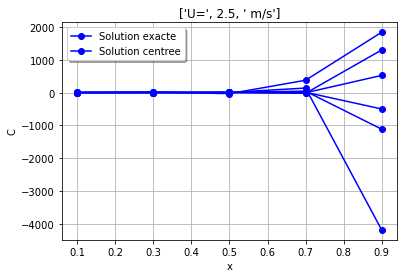

In [49]:
# FIGURE

xtot        = np.ones(shape=m+2)
xtot[1:m+1] = xp
xtot[0]     = xstart
xtot[-1]    = xend

Cexact = C0 + (CL-C0) * (np.exp(rhoval*Uval*xtot/gamma_x)-1)/(np.exp(rhoval*Uval*xend/gamma_x)-1)

# --------------------------------

plt.figure()

#plt.plot(xtot, Cexact, 'kx-')
plt.plot(xtot[1:-1], c_sol[1:-1,1:-1], 'bo-')

plt.xlabel('x')
plt.ylabel('C')
plt.title(['U=', Uval, ' m/s'])

plt.legend(('Solution exacte', 'Solution centree'), loc='best', shadow=True)
plt.grid(True)

# --------------------------------

plt.savefig('Figures/Test.png')
plt.show()

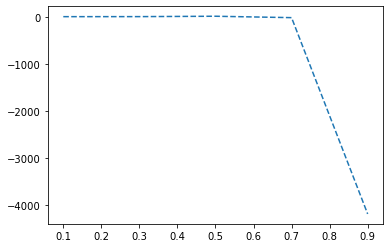

In [50]:
plt.plot([0.1, 0.3, 0.5, 0.7, 0.9], np.diag(c_sol[1:-1,1:-1]), '--')